# Train Model
In this notebook, we will create and train a model to predict the sentiment of a movie review.

In [58]:
import pandas as pd
import numpy as np
import re
from keras_nlp.models import Tokenizer

In [59]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.losses import CategoricalCrossentropy
from tqdm import tqdm

In [60]:
# Load the data
df = pd.read_csv('data/preprocessed_dataset.csv')

In [61]:
df.drop(columns=['text']).head(5)

,anger,boredom,empty,excitement,amusement,joy,disgust,love,neutral,relief,...,disappointment,gratitude,grief,pride,curiosity,optimism,annoyance,approval,remorse,admiration
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


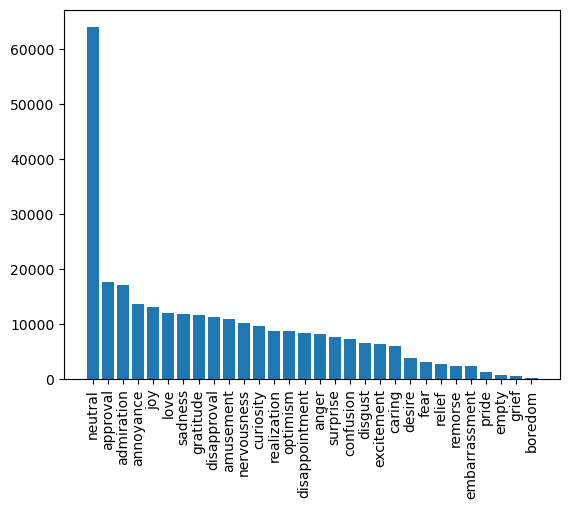

In [62]:
import matplotlib.pyplot as plt

# Plot the frequency of each sentiment from the most frequent to the least frequent
# This will help us determine which sentiments to drop to balance the dataset
collsWoText = df.columns.drop('text')

# Create a mapping of sentiment to frequency
sentiment_freq = { i : df[i].sum() for i in collsWoText}
# Sort the mapping by frequency
sentiment_freq = dict(sorted(sentiment_freq.items(), key=lambda item: item[1], reverse=True))
# Plot the frequency of each sentiment
plt.bar(sentiment_freq.keys(), sentiment_freq.values())
plt.xticks(rotation=90)
plt.show()


In [63]:
# Drop the some rows that belong to the most frequent sentiments which neutral, approval and admiration to balance the dataset
df = df.drop(df[df['neutral'] == 1].sample(frac=.8).index)
df = df.drop(df[df['approval'] == 1].sample(frac=.2).index)
df = df.drop(df[df['admiration'] == 1].sample(frac=.17).index)

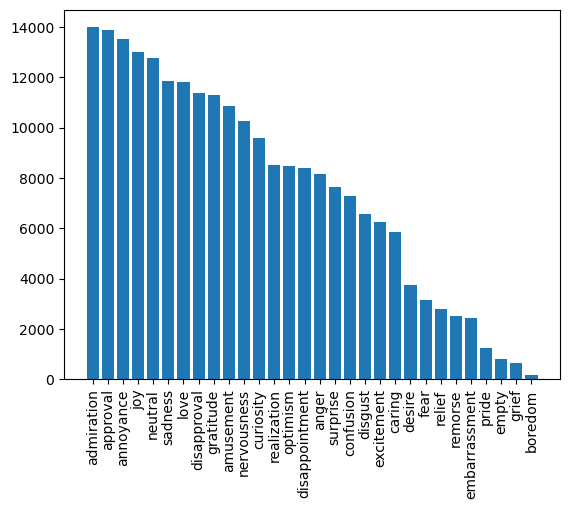

In [64]:
# Plot the frequency of each sentiment after balancing the dataset
sentiment_freq = { i : df[i].sum() for i in collsWoText}
sentiment_freq = dict(sorted(sentiment_freq.items(), key=lambda item: item[1], reverse=True))
plt.bar(sentiment_freq.keys(), sentiment_freq.values())
plt.xticks(rotation=90)
plt.show()
# Balanced enough

In [65]:
df_new = df.drop(columns=['text'])

In [66]:
# Find frequency of easch sentiment
df_new.sum()

anger              8159
boredom             179
empty               827
excitement         6247
amusement         10870
joy               12999
disgust            6581
love              11822
neutral           12787
relief             2786
sadness           11871
surprise           7641
nervousness       10255
confusion          7299
desire             3744
disapproval       11375
embarrassment      2451
caring             5867
realization        8534
fear               3175
disappointment     8383
gratitude         11303
grief               666
pride              1244
curiosity          9578
optimism           8478
annoyance         13542
approval          13899
remorse            2505
admiration        13990
dtype: int64

In [67]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df_new, test_size=0.2, random_state=42)

# Initialize TextVectorization layer
max_features = 5000  # Maximum number of words to consider
sequence_length = 28  # Maximum length of a sequence

# Ensure X_train and X_test are of type str
X_train = X_train.astype(str)
X_test = X_test.astype(str)

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int', # float?
    output_sequence_length=sequence_length
)

# Adapt the vectorize layer to the training data
vectorize_layer.adapt(X_train.values)

# Vectorize the training and testing data
X_train_vectorized = vectorize_layer(X_train.values)
X_test_vectorized = vectorize_layer(X_test.values)

# Convert y_train and y_test to numpy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [68]:
# Find longest review
max_len = 0
for review in tqdm(X_train.values):
    max_len = max(max_len, len(review.split()))
max_len

100%|██████████| 153123/153123 [00:00<00:00, 944756.33it/s]


26

In [69]:
#llok up x_train vector
X_train_vectorized[125236]

<tf.Tensor: shape=(28,), dtype=int64, numpy=
array([ 242,  163,    3,    3, 1293,  632, 2256,    1,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int64)>

In [74]:
# Build the model
model = Sequential()
model.add(Embedding(max_features, 128, input_length=sequence_length))
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(30, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
model.fit(X_train_vectorized, y_train, epochs=4, batch_size=32, validation_data=(X_test_vectorized, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_vectorized, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/4
4786/4786 [==============================] - 58s 11ms/step - loss: 3.8867 - accuracy: 0.0532 - val_loss: 3.9026 - val_accuracy: 0.0509
Epoch 2/4
4786/4786 [==============================] - 53s 11ms/step - loss: 3.9011 - accuracy: 0.0524 - val_loss: 3.9378 - val_accuracy: 0.0449
Epoch 3/4
4786/4786 [==============================] - 51s 11ms/step - loss: 3.9214 - accuracy: 0.0526 - val_loss: 3.9301 - val_accuracy: 0.0509
Epoch 4/4
1197/1197 [==============================] - 6s 5ms/step - loss: 3.9494 - accuracy: 0.0509
Test Loss: 3.9493958950042725
Test Accuracy: 0.050886861979961395


In [71]:
# Train with whole dataset

# Ensure x is of type string
df['text'] = df['text'].astype(str)

# Vectorize the whole dataset
X_vectorized = vectorize_layer(df['text'].values)


# Convert y to numpy arrays
y = df_new.to_numpy()

# Compile the model
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
model.fit(X_vectorized, y, epochs=4, batch_size=32)

Epoch 1/4
5982/5982 [==============================] - 21s 3ms/step - loss: 3.8376 - accuracy: 0.0473
Epoch 2/4
5514/5982 [==========================>...] - ETA: 1s - loss: 3.8378 - accuracy: 0.0467

KeyboardInterrupt: 

# Save the model


In [ ]:
from tensorflow.keras.models import save_model

# Save the model
save_model(model, 'models/sentiment_model')

In [ ]:
# Print versions 
import tensorflow as tf
import keras_nlp
print(f'Tensorflow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')
print(f'Keras NLP version: {keras_nlp.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
